import tensorflow.keras as tfk
import tensorflow as tf
import numpy as np
import cv2 as cv
import tensorflow.keras.backend as K

In [1]:
import keras as tfk
import keras.backend as K
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn as sk

Using TensorFlow backend.


## Creación del modelo

In [2]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model = tfk.models.Sequential([tfk.layers.Conv2D(64,(3,3),input_shape=(150,150,3)),
                              tfk.layers.MaxPooling2D(),
                              tfk.layers.Conv2D(32,(3,3)),
                              tfk.layers.MaxPooling2D(),
                              tfk.layers.Conv2D(16,(3,3)),
                              tfk.layers.MaxPooling2D(),
                              tfk.layers.Conv2D(8,(3,3)),
                              tfk.layers.MaxPooling2D(),
                              tfk.layers.Conv2D(4,(3,3)),
                              tfk.layers.MaxPooling2D()])

In [5]:
post_model = tfk.models.Sequential([model,
                                    tfk.layers.Flatten(),
                                   tfk.layers.Dense(128,activation='relu'),
                                   tfk.layers.Dropout(0.2),
                                   tfk.layers.Dense(64,activation='relu'),
                                  tfk.layers.Dropout(0.2),
                                   tfk.layers.Dense(32,activation='relu')])

In [6]:
def euclidian_distance(vects):
    x,y = vects
    return K.sqrt(K.sum(K.square(x-y),axis=1,keepdims=True))

In [7]:
def ed_output_shape(shapes):
    shape1,shape2 = shapes
    return (shape1[0],1)

In [8]:
distance = tfk.layers.Lambda(euclidian_distance,output_shape=ed_output_shape)

In [9]:
img_a = tfk.layers.Input(shape=(150,150,3))

img_b = tfk.layers.Input(shape=(150,150,3))

In [10]:
feat_vecs_a = post_model(img_a)

In [11]:
feat_vecs_b = post_model(img_b)

In [12]:
distance = distance([feat_vecs_a,feat_vecs_b])

In [13]:
full_model = tfk.models.Model(inputs=[img_a,img_b],output=distance)

d:\programas\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


In [14]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32)           38844       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_2[1][0]         

In [15]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [16]:
full_model.compile(loss=contrastive_loss,optimizer=tfk.optimizers.rmsprop())

________

## Generación de Datasets

In [17]:
def build_path(base_path,it1,it2):
    return f'{base_path}p{it1}/{it2}.jpg'

In [18]:
def read_image(path):
    return cv.imread(path)

In [19]:
def preprocess_image(image):
    cc_im1=cv.resize(image,(150,150))
    cc_im1 = np.reshape(cc_im1,(150,150,3))
    return cc_im1/255

In [20]:
def generate_dataset():
    base_path = "./images/Cats/"
    total_samples_per_state = 1000
    tspe = total_samples_per_state
    x_positive = np.zeros([tspe, 2,150, 150,3])
    y_positive = np.zeros([tspe, 1])
    
    count = 0
    for i in range(12):
        for _ in range(tspe//12):
            s1,s2 = 0,0
            while s1==s2:
                s1,s2 = np.random.randint(160),np.random.randint(160)
            x1 = preprocess_image(read_image(build_path(base_path,i+1,s1+1)))
            x2 = preprocess_image(read_image(build_path(base_path,i+1,s2+1)))
            x_positive[count,0,...] = x1
            x_positive[count,1,...] = x2
            y_positive[count,0] = 1
            count +=1
            
            
    x_negative = np.zeros([tspe, 2,150, 150,3])
    y_negative = np.zeros([tspe, 1])
    count=0
    for i in range(12):
        for _ in range(tspe//12):
            s1,s2 = i,0
            while s1 == i:
                s1,s2,s3 = np.random.randint(12),np.random.randint(160),np.random.randint(160)
            x1 = preprocess_image(read_image(build_path(base_path,i+1,s2+1)))
            x2 = preprocess_image(read_image(build_path(base_path,s1+1,s3+1)))
            x_negative[count,0,...] = x1
            x_negative[count,1,...] = x2
            y_negative[count,0] = 0
            count+=1
    total_x = np.concatenate([x_positive,x_negative],axis=0)
    total_y = np.concatenate([y_positive,y_negative],axis=0)
    
    return total_x,total_y

In [21]:
x,y=generate_dataset()

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

In [23]:
del(x)

In [24]:
del(y)

In [25]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]

In [26]:
del(x_train)

full_model.load_weights('Cat_N-O_Limit.ckpt')

In [31]:
history=full_model.fit([img_1,img_2],y_train,epochs=30,verbose=2,validation_data=[[x_test[:, 0], x_test[:, 1]],y_test])

Train on 1500 samples, validate on 500 samples
Epoch 1/30
 - 8s - loss: 0.1443 - val_loss: 0.2941
Epoch 2/30
 - 8s - loss: 0.1311 - val_loss: 0.2860
Epoch 3/30
 - 8s - loss: 0.1310 - val_loss: 0.2897
Epoch 4/30
 - 8s - loss: 0.1300 - val_loss: 0.2891
Epoch 5/30
 - 8s - loss: 0.1230 - val_loss: 0.2851
Epoch 6/30
 - 8s - loss: 0.1211 - val_loss: 0.3046
Epoch 7/30
 - 8s - loss: 0.1170 - val_loss: 0.2999
Epoch 8/30
 - 8s - loss: 0.1121 - val_loss: 0.3204
Epoch 9/30
 - 8s - loss: 0.1102 - val_loss: 0.3166
Epoch 10/30
 - 8s - loss: 0.1087 - val_loss: 0.3288
Epoch 11/30
 - 8s - loss: 0.1042 - val_loss: 0.3304
Epoch 12/30
 - 8s - loss: 0.1084 - val_loss: 0.3119
Epoch 13/30
 - 8s - loss: 0.1044 - val_loss: 0.3290
Epoch 14/30
 - 8s - loss: 0.0977 - val_loss: 0.3116
Epoch 15/30
 - 8s - loss: 0.0971 - val_loss: 0.3136
Epoch 16/30
 - 8s - loss: 0.0986 - val_loss: 0.3322
Epoch 17/30
 - 8s - loss: 0.0909 - val_loss: 0.3325
Epoch 18/30
 - 8s - loss: 0.0920 - val_loss: 0.3421
Epoch 19/30
 - 8s - loss: 

In [28]:
lss = history.history['loss']
vlss = history.history['val_loss']

In [29]:
%matplotlib inline

<Figure size 432x288 with 0 Axes>

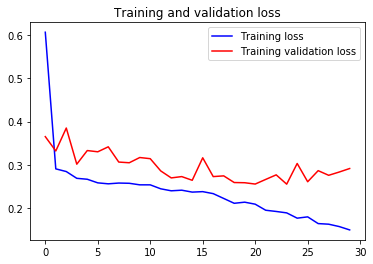

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(lss, 'b', label='Training loss')
plt.plot(vlss, 'r', label='Training validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [31]:
pred = full_model.predict([x_test[:, 0], x_test[:, 1]])

In [32]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.2].mean()

compute_accuracy(pred,y_test)

0.515625

In [33]:
prom = 0
trues = []
for i in range(len(pred)):
    if y_test.ravel()[i]:
        prom+=pred.ravel()[i]
        trues.append(pred.ravel()[i])
prom /= len(pred)
trues.sort()

In [34]:
promf = 0
falses = []
for i in range(len(pred)):
    if y_test.ravel()[i] == 0:
        promf+=pred.ravel()[i]
        falses.append(pred.ravel()[i])
promf /= len(pred)
falses.sort()

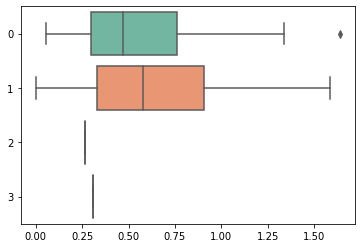

In [35]:
sns.boxplot(data=(trues,falses,prom,promf),orient="h", palette="Set2")

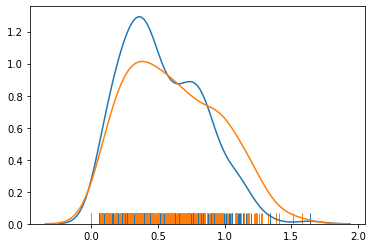

In [36]:
sns.distplot(trues, hist=False, rug=True)
sns.distplot(falses, hist=False, rug=True)

In [37]:
compute_accuracy(pred,y_test)

0.515625

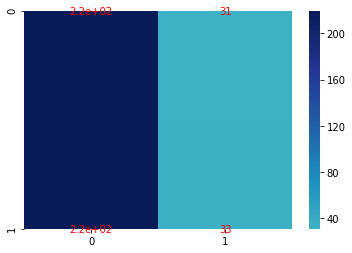

In [38]:
threshold = .2
cm = sk.metrics.confusion_matrix(y_test.ravel(), pred.ravel()<threshold)
sns.heatmap(data=cm,annot=True,cmap='YlGnBu',center=25,annot_kws={'color':'r'})

full_model.save_weights('Cat_N-O_Limit.ckpt')

In [39]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

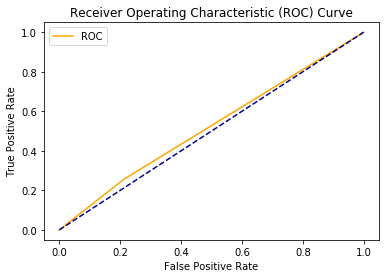

In [40]:
a,b,c=sk.metrics.roc_curve(y_test.ravel(),pred.ravel()<0.3)
plot_roc_curve(a,b)